In [1]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt# specify GPU 
from torchinfo import summary
device = torch.device("cuda")

/home/icksir/miniconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

In [2]:
df = pd.read_csv("category.csv")
df.head()

,text,label
0,Hola,saludo
1,Cómo estás,saludo
2,como estas,saludo
3,holaaaa,saludo
4,holap,saludo


In [3]:
df['label'].value_counts()

label
saludo       9
despedida    8
equipo       5
Name: count, dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label']) # check class distribution
df['label'].value_counts(normalize = True)

label
2    0.409091
0    0.363636
1    0.227273
Name: proportion, dtype: float64

In [5]:
train_text, train_labels = df['text'], df['label']

# Data preparation and model

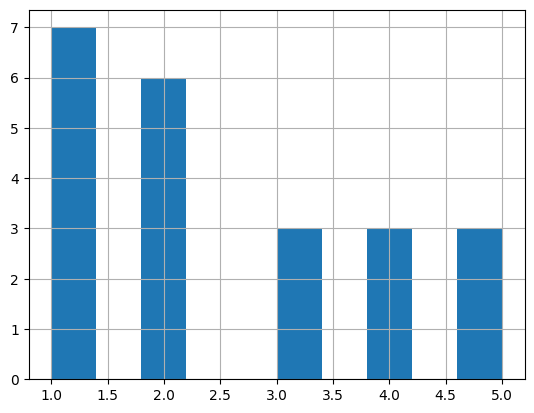

In [6]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)# Based on the histogram we are selecting the max len as 8

max_seq_len = 8

In [7]:
from transformers import pipeline

qa_model = pipeline("question-answering", "timpal0l/mdeberta-v3-base-squad2")

In [8]:
tokenizer = qa_model.tokenizer

In [74]:
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

In [10]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler#define a batch size
batch_size = 8# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [147]:
class BERT_Arch(nn.Module):   
    def __init__(self, qa_model, out_features):      
        super(BERT_Arch, self).__init__()       

        self.bert = qa_model.model.base_model
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.2)
        
        # relu activation function
        self.relu =  nn.ReLU()       # dense layer       
        self.fc1 = nn.Linear(768, 512)              
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, out_features)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)       #define the forward pass

    def forward(self, sent_id, mask):      #pass the inputs to the model  
        cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
   
        # apply softmax activation
        x = self.softmax(x)
    
        return x

In [148]:
for param in qa_model.model.parameters():
      param.requires_grad = False
      model = BERT_Arch(qa_model, 3) # push the model to GPU

model = model.to(device)
summary(model, col_names=("trainable", "num_params"))

Layer (type:depth-idx)                                            Trainable                 Param #
BERT_Arch                                                         Partial                   --
├─DebertaV2Model: 1-1                                             False                     --
│    └─DebertaV2Embeddings: 2-1                                   False                     --
│    │    └─Embedding: 3-1                                        False                     (192,768,000)
│    │    └─LayerNorm: 3-2                                        False                     (1,536)
│    │    └─StableDropout: 3-3                                    --                        --
│    └─DebertaV2Encoder: 2-2                                      False                     --
│    │    └─ModuleList: 3-4                                       False                     (85,054,464)
│    │    └─Embedding: 3-5                                        False                     (393,216)
│    │    └─

## Train model

In [149]:
from transformers import AdamW# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/home/icksir/miniconda3/envs/pytorch/lib/python3.12/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [150]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
print(class_wts)

[0.91666667 1.46666667 0.81481481]


In [151]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [152]:
# empty lists to store training and validation loss of each epoch
train_losses=[]# number of training epochs
epochs = 200

In [153]:
# function to train the model
def train():
  
    model.train()  
    total_loss = 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))   

      # push the batch to gpu
        batch = [r.to(device) for r in batch] 
        sent_id, mask, labels = batch    # get model predictions for the current batch
        preds = model(sent_id, mask)    # compute the loss between actual and predicted values
        
        loss = cross_entropy(preds, labels)    # add on to the total loss
        total_loss = total_loss + loss.item()    # backward pass to calculate the gradients
        loss.backward()    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    # update parameters
        optimizer.step()    # clear calculated gradients
        optimizer.zero_grad()
  
    # We are not using learning rate scheduler as of now
    # lr_sch.step()    # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()    # append the model predictions
        total_preds.append(preds)# compute the training loss of the epoch
    
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions
    return avg_loss, total_preds

In [154]:
for epoch in range(epochs):
         
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'Epoch: {epoch} | Training Loss: {train_loss:.3f}')

Epoch: 0 | Training Loss: 1.101
Epoch: 1 | Training Loss: 1.069
Epoch: 2 | Training Loss: 1.047
Epoch: 3 | Training Loss: 0.970
Epoch: 4 | Training Loss: 0.959
Epoch: 5 | Training Loss: 0.778
Epoch: 6 | Training Loss: 0.673
Epoch: 7 | Training Loss: 0.750
Epoch: 8 | Training Loss: 0.711
Epoch: 9 | Training Loss: 0.608
Epoch: 10 | Training Loss: 0.651
Epoch: 11 | Training Loss: 0.674
Epoch: 12 | Training Loss: 0.469
Epoch: 13 | Training Loss: 0.622
Epoch: 14 | Training Loss: 0.375
Epoch: 15 | Training Loss: 0.322
Epoch: 16 | Training Loss: 0.504
Epoch: 17 | Training Loss: 0.633
Epoch: 18 | Training Loss: 0.446
Epoch: 19 | Training Loss: 0.504
Epoch: 20 | Training Loss: 0.655
Epoch: 21 | Training Loss: 0.599
Epoch: 22 | Training Loss: 0.486
Epoch: 23 | Training Loss: 0.349
Epoch: 24 | Training Loss: 0.465
Epoch: 25 | Training Loss: 0.861
Epoch: 26 | Training Loss: 0.522
Epoch: 27 | Training Loss: 0.472
Epoch: 28 | Training Loss: 0.631
Epoch: 29 | Training Loss: 0.551
Epoch: 30 | Training

In [155]:
data = {"intents": [
    {"tag": "saludo", "responses": ["Hola!", "Hola", "Hola :)"]},
    {"tag": "despedida", "responses": ["Adios", "Hasta pronto"]},
    {"tag": "equipo", "responses": ["Somos Mining Track"]},
]}

In [156]:
def get_prediction(str):
    str = re.sub(r'[^a-zA-Z ]+', '', str)
    test_text = [str]
    model.eval()
    
    tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
    ) 
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])
    
    preds = None 
    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device)) 

    preds = preds.detach().cpu().numpy()

    print("predicciones:", preds)

    preds = np.argmax(preds, axis = 1)

    print("indice:", preds)

    print("Intent Identified: ", le.inverse_transform(preds)[0])
    return le.inverse_transform(preds)[0]

def get_response(message): 
    intent = get_prediction(message)
    result = ""
    intent = re.sub(r'[^a-zA-Z]+', '', intent)

    for i in data['intents']: 
        if i["tag"] == intent and result == '':
            result = random.choice(i["responses"])
        
    print(f"Response : {result}")

In [157]:
get_response("no los conozco")

predicciones: [[-2.1944022e-04 -1.6283913e+01 -8.4253387e+00]]
indice: [0]
Intent Identified:  despedida
Response : Hasta pronto


In [132]:
-7.2238571e-04

-0.00072238571

In [133]:
-8.2370228e-04

-0.00082370228

In [158]:
-2.1944022e-04

-0.00021944022